# 1. Load dataset

In [1]:
from datasets import load_dataset

# Load only the test split of the CoNLL-2003 dataset
raw_dataset = load_dataset("conll2003", split="test")
raw_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})

# 3. Get labels

In [2]:
ner_feature = raw_dataset.features["ner_tags"]
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# 2. Load fine-tuned models from the HuggingFace

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model_names = ["GustawB/albert-finetuned-ner", "GustawB/distilbert-finetuned-ner", "GustawB/bert-finetuned-ner"]
model_tokenizers = {}
models = {}
# Load tokenizers and models in an automatic fashion
for name in model_names:
    model_tokenizers[name] = AutoTokenizer.from_pretrained(name)
    models[name] = AutoModelForTokenClassification.from_pretrained(
        name,
        id2label=id2label,
        label2id=label2id,
    )

# 3 Tokenize and align labels

In [4]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [5]:
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [6]:
tokenized_datasets = {}
for name in model_names:
    tokenized_datasets[name] = raw_dataset.map(
        lambda examples: tokenize_and_align_labels(examples, model_tokenizers[name]),
        batched=True,
        remove_columns=raw_dataset.column_names,
    )
tokenized_datasets

{'GustawB/albert-finetuned-ner': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 3453
 }),
 'GustawB/distilbert-finetuned-ner': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 3453
 }),
 'GustawB/bert-finetuned-ner': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 3453
 })}

# 4. Collate the datasets

In [7]:
from transformers import DataCollatorForTokenClassification

collators = {}
for name in model_names:
    collators[name] = DataCollatorForTokenClassification(tokenizer=model_tokenizers[name])

# 5. Define metrics

In [8]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

# 6. Evaluate models

In [9]:
from pprint import pprint
from transformers import Trainer, TrainingArguments
from memory_profiler import memory_usage

results = {}
resource_logs = {}
for name in model_names:    
    args = TrainingArguments(
        per_device_eval_batch_size=8,
        output_dir="./results",
        logging_dir="./logs",
    )
    
    trainer = Trainer(
        model=models[name],
        data_collator=collators[name],
        args=args,
        compute_metrics=compute_metrics,
        tokenizer=model_tokenizers[name],
    )
    
    def evaluation():
        results[name] = trainer.evaluate(tokenized_datasets[name])
        
    resource_logs[name] = memory_usage(evaluation)
    
pprint(results)
pprint(resource_logs)

/tmp/ipykernel_33925/3102127428.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'GustawB/albert-finetuned-ner': {'eval_accuracy': 0.875939553426514,
                                  'eval_f1': 0.46400291253299353,
                                  'eval_loss': 0.39715638756752014,
                                  'eval_model_preparation_time': 0.0011,
                                  'eval_precision': 0.47743023038022103,
                                  'eval_recall': 0.4513101983002833,
                                  'eval_runtime': 94.0944,
                                  'eval_samples_per_second': 36.697,
                                  'eval_steps_per_second': 4.591},
 'GustawB/bert-finetuned-ner': {'eval_accuracy': 0.9711318762704654,
                                'eval_f1': 0.8986086956521739,
                                'eval_loss': 0.19799554347991943,
                                'eval_model_preparation_time': 0.003,
                                'eval_precision': 0.882946001367054,
                                'eval_recall': 0.

# 7. Plot the results

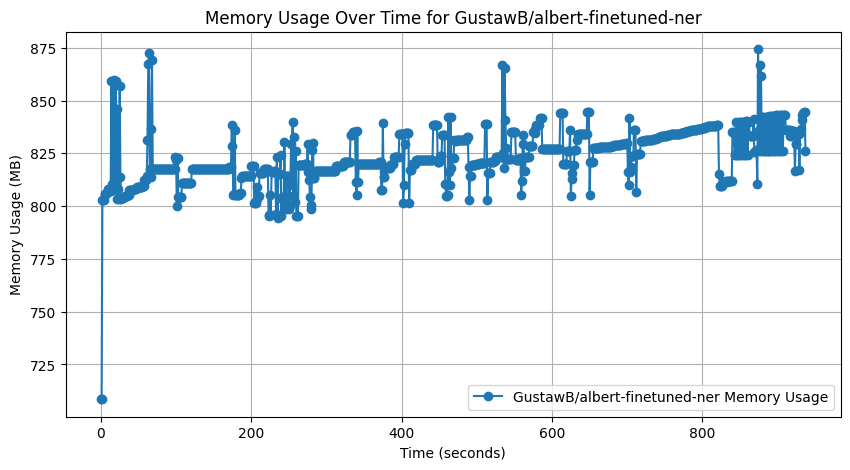

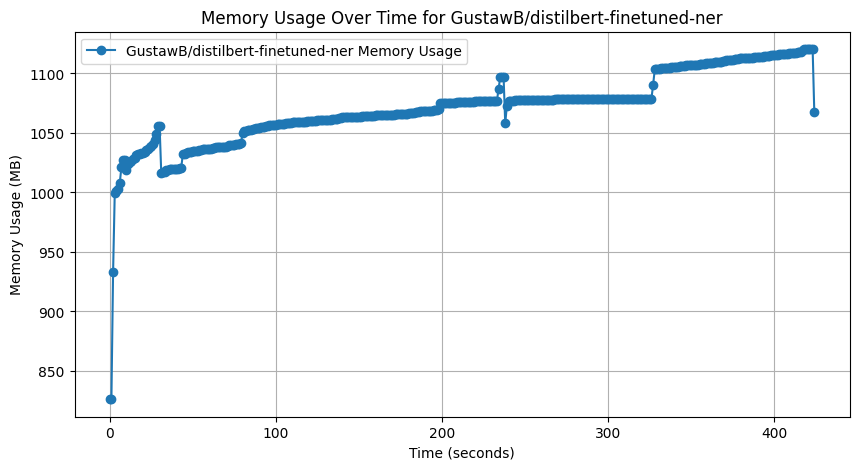

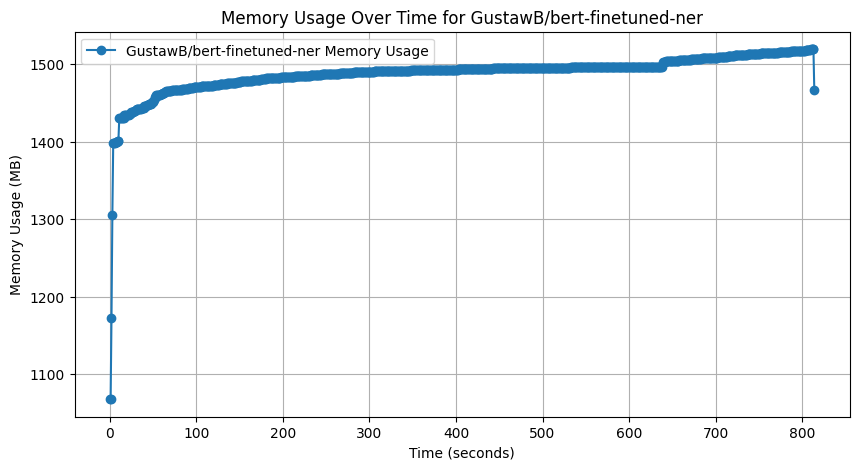

In [10]:
import matplotlib.pyplot as plt

# Loop over each model in the dictionary and plot its memory usage
for model_name, mem_usage in resource_logs.items():
    plt.figure(figsize=(10, 5))
    plt.plot(mem_usage, label=f"{model_name} Memory Usage", marker='o')
    plt.title(f"Memory Usage Over Time for {model_name}")
    plt.xlabel("Timestamps")
    plt.ylabel("Memory Usage (MB)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 8. Future improvements

First of all, plots above have imaginary time axis. It would be nice to measure the time of the evaluation process and plot the memory usage against it. Right now we can observe how the mem usage changes, but against some undefined notion of time. \
Second of all, memory_profiler. It returns something, according to docs its mem usage in megabytes, but it's just a list of numbers, so it would be nice to process it more/look in docs for more (though for now that lead me to more bugs than solutions). Also, I'm not sure if it's not measuring memory usage of the whole env (Pycharm etc). The first time I ran it, I got memory usage of 4gb, but after the Pycharm restart I only got about 1-1,5gb. Because of that (and because memory_profiler has cmd api) it would be nice to have a bash script that would run tests instead of running them from the notebook. 